In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import pdist
from IPython.display import HTML

In [2]:
# if you have difficulties with ffmpeg to run the simulation, see https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available
# plt.rcParams['animation.ffmpeg_path'] = your_windows_path
plt.rcParams['animation.ffmpeg_args'] = '-report'
plt.rcParams['animation.bitrate'] = 2000

%matplotlib notebook
pd.options.display.float_format = '{:,.2f}'.format

### Load Iris Data

In [3]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [4]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

### Create DataFrame

In [5]:
# 构造Iris数据集
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


### Standardize Data

In [6]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [7]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

<IPython.core.display.Javascript object>


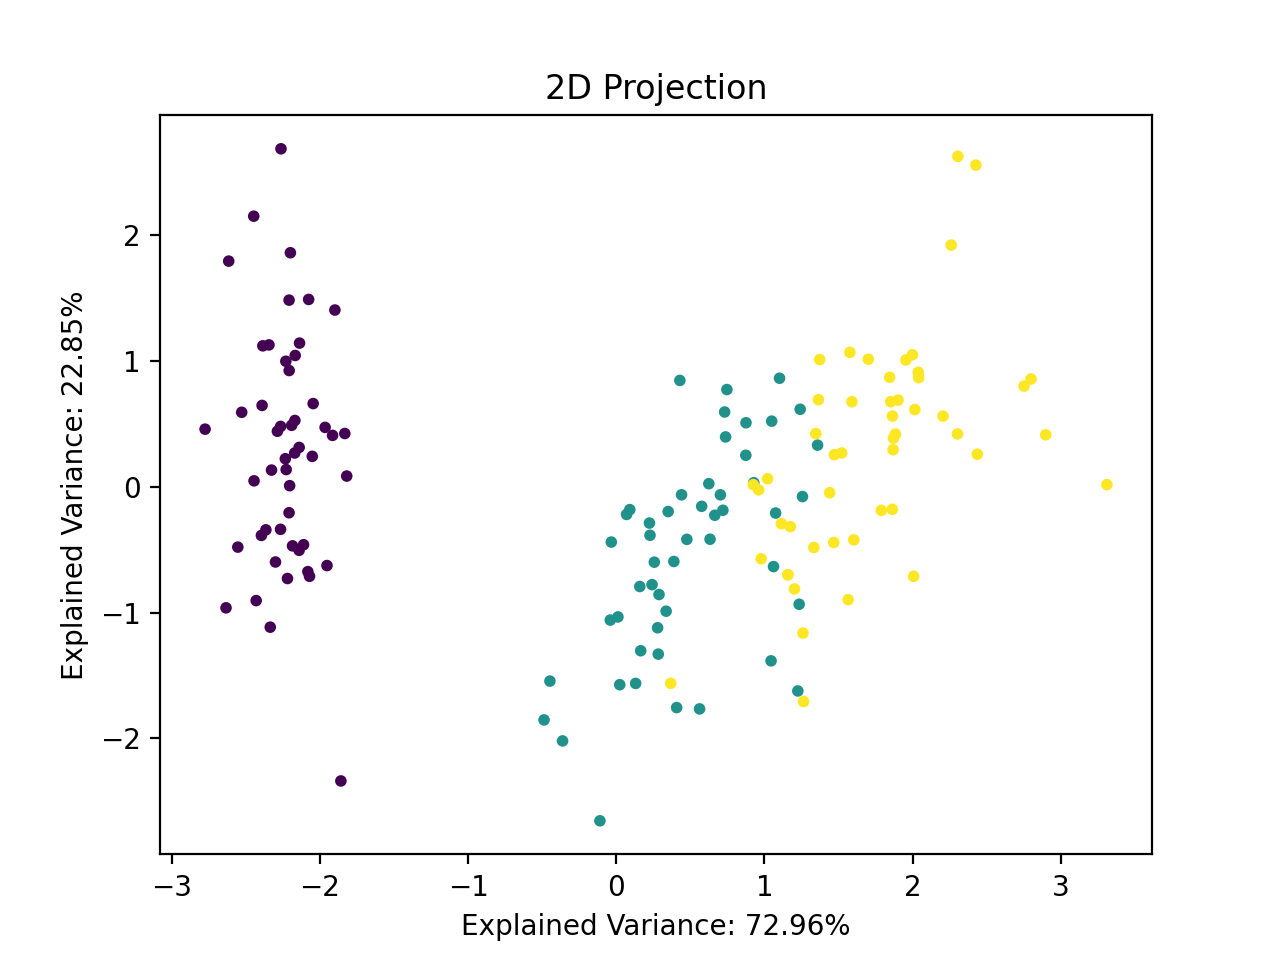

In [8]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure().gca(title='2D Projection', 
                      xlabel='Explained Variance: {:.2%}'.format(ev1), 
                      ylabel='Explained Variance: {:.2%}'.format(ev2))
ax.scatter(*features_2D.T, c=data.label, s=10)

### 不同距离度量方式的层次聚类

In [9]:
# 距离度量方法实现：linkage
Z = linkage(features_standardized, 'ward')
Z[:5]

array([[1.01000000e+02, 1.42000000e+02, 0.00000000e+00, 2.00000000e+00],
       [7.00000000e+00, 3.90000000e+01, 1.21167870e-01, 2.00000000e+00],
       [1.00000000e+01, 4.80000000e+01, 1.21167870e-01, 2.00000000e+00],
       [9.00000000e+00, 3.40000000e+01, 1.31632184e-01, 2.00000000e+00],
       [0.00000000e+00, 1.70000000e+01, 1.31632184e-01, 2.00000000e+00]])

In [10]:
linkage_matrix = pd.DataFrame(data=Z, 
                              columns=['cluster_1', 'cluster_2', 
                                       'distance', 'n_objects'],
                              index=range(1, n))
for col in ['cluster_1', 'cluster_2', 'n_objects']:
    linkage_matrix[col] = linkage_matrix[col].astype(int)
linkage_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 1 to 149
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cluster_1  149 non-null    int64  
 1   cluster_2  149 non-null    int64  
 2   distance   149 non-null    float64
 3   n_objects  149 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 4.8 KB


### Compare linkage types

In [11]:
# 对比四种距离度量方式的聚类效果
methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(features_standardized)

<IPython.core.display.Javascript object>


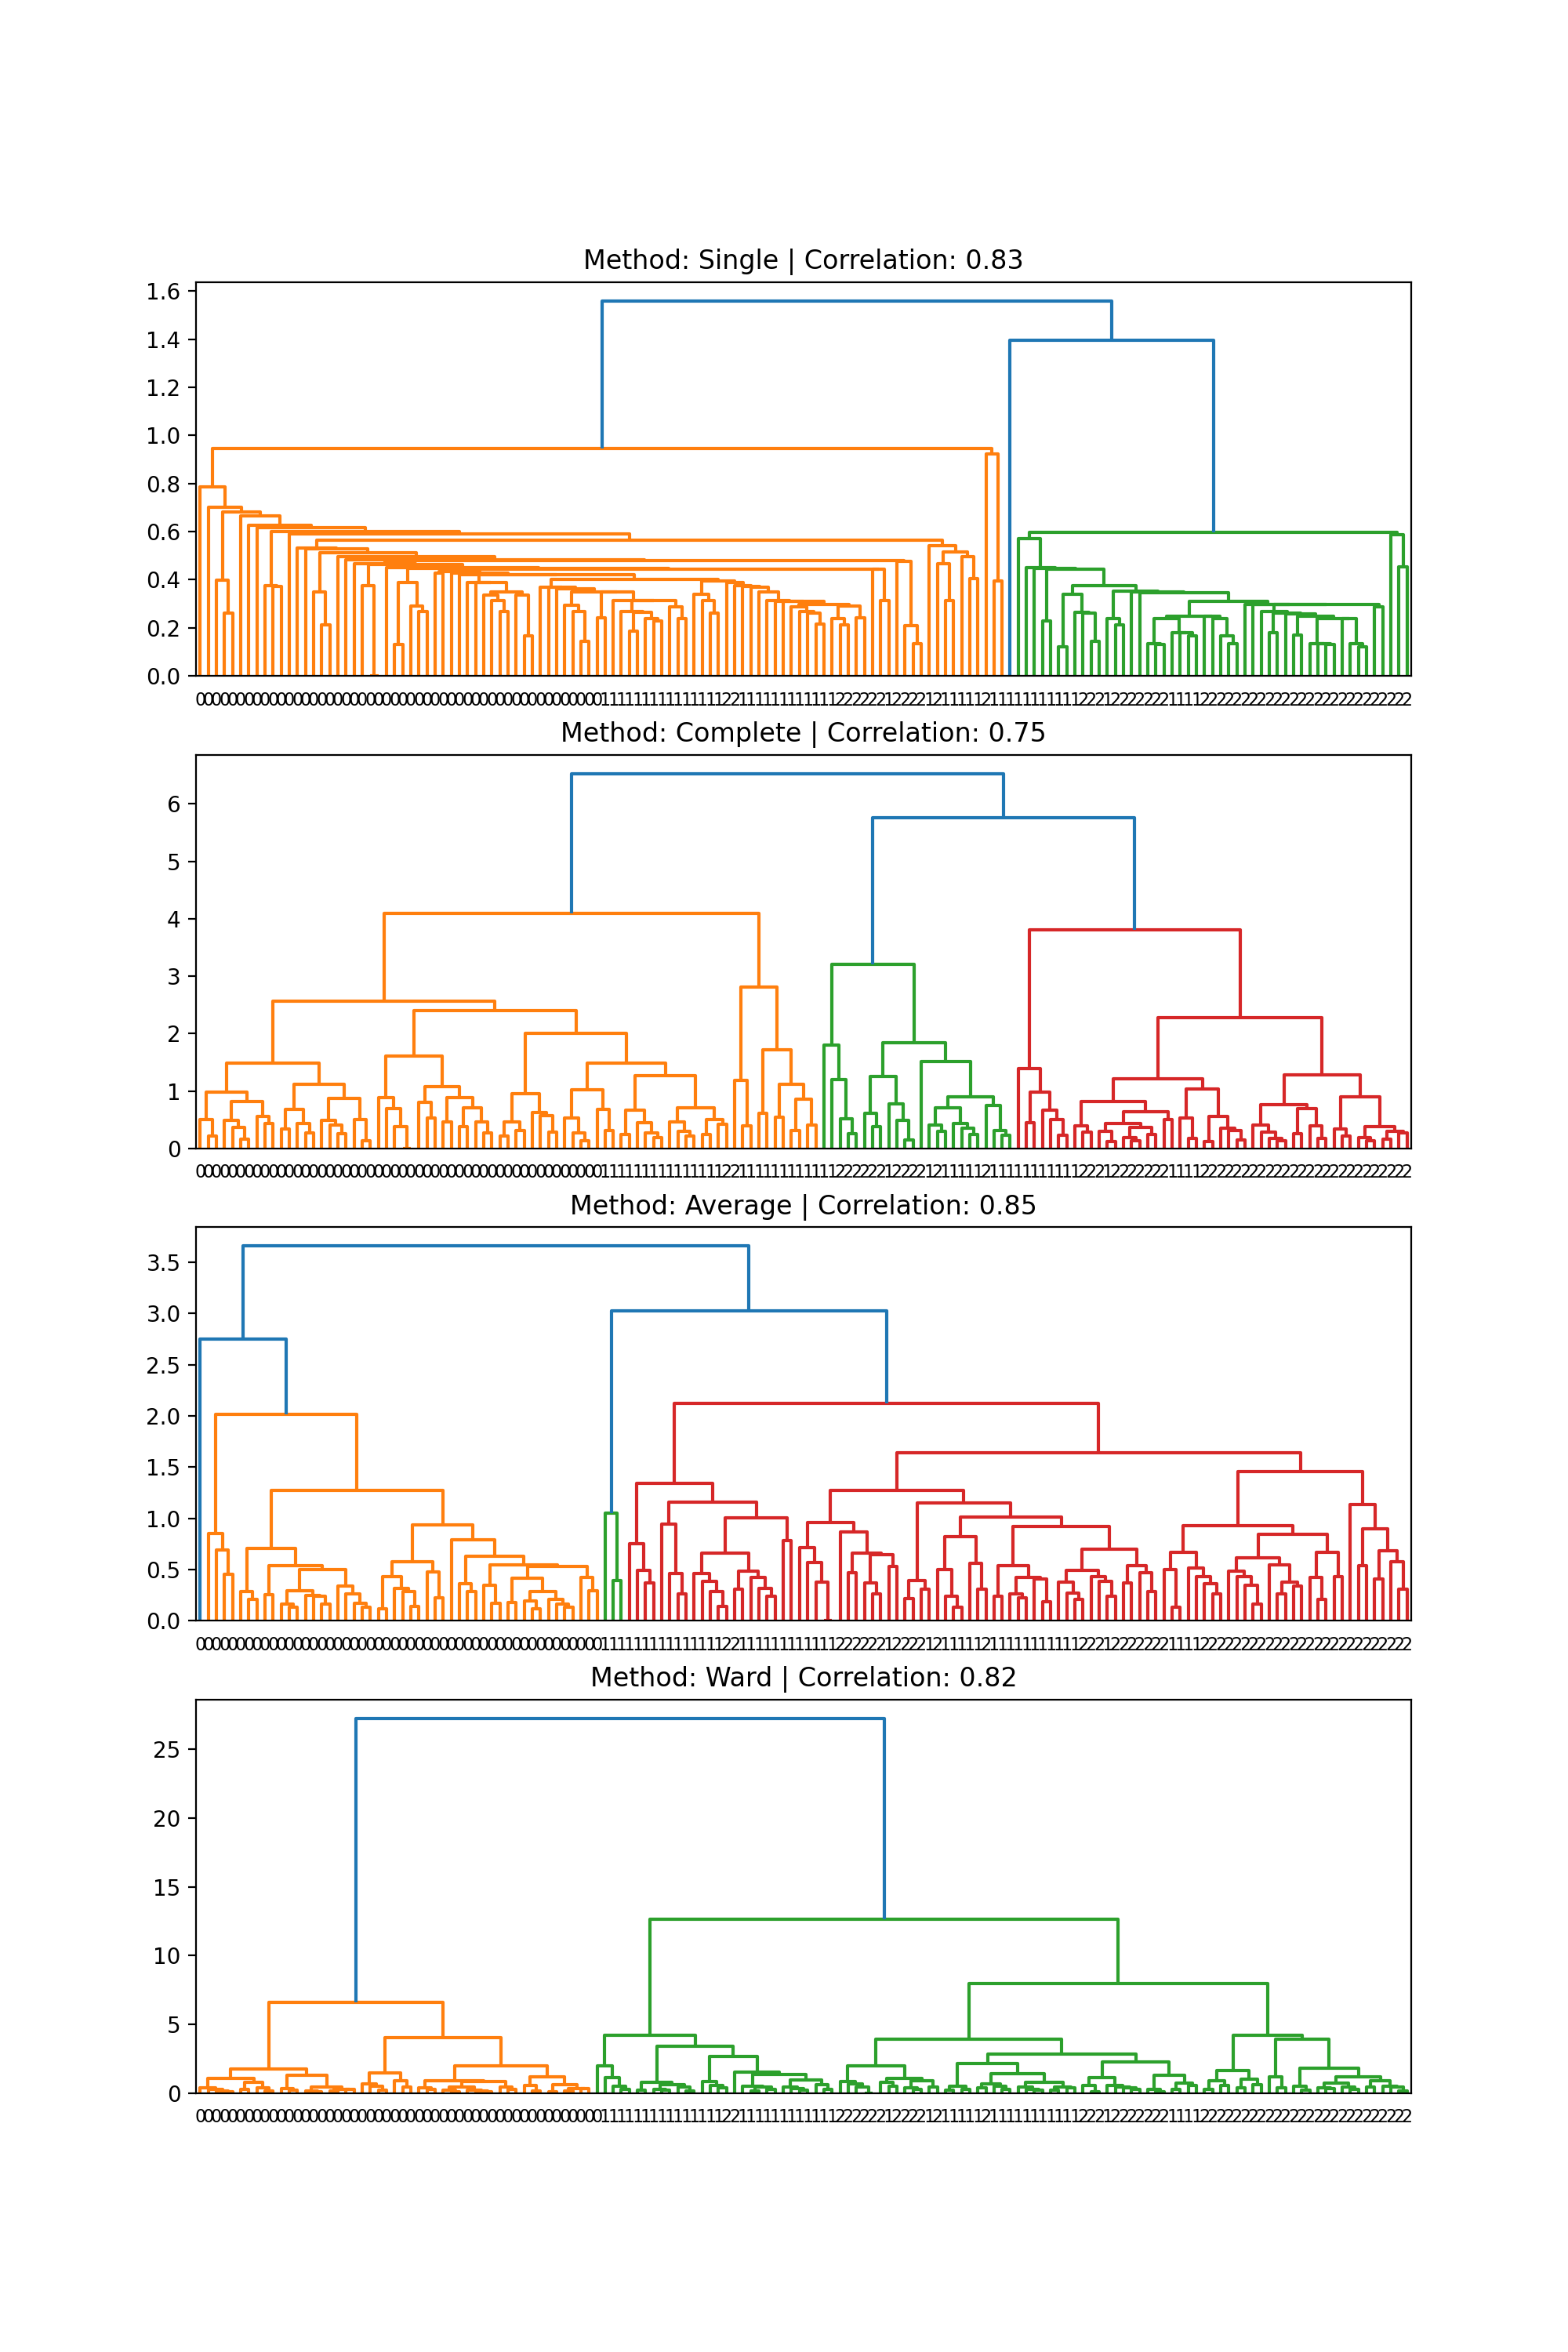

In [12]:
fig, axes = plt.subplots(figsize=(10, 15), nrows=4, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    Z = linkage(features_standardized, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z, labels=data.label.values,
        orientation='top', leaf_rotation=0., 
        leaf_font_size=8., ax = axes[i])
    axes[i].set_title('Method: {} | Correlation: {:.2f}'.format(method.capitalize(), c))
